# AUTHOR
***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-05-20**

# Multi-class SVM

## SUMMARY

### Loss function of Multi-class SVM:
$~~~~\mathcal{L}(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) + \frac{\lambda}{2} ||\mathbf{W}||_F^2~~~~$

- Explain symbols:
 - $\mathbf{x}_n$ is extended data point
 - C is number of classes
 - $\mathbf{x}_n \in \mathbf{R}^d → \mathbf{X} \in  \mathbf{R}^{d×N}$
 - $\mathbf{W} \in \mathbf{R}^{d×C}$

### Gradient of loss function (Temporarily ignore the multiplier $\frac{1}{N}$):
$\begin{eqnarray}
\frac{\partial }{\partial \mathbf{w}_{y_n}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& 
\left\{
\begin{matrix}
0 & \text{if}& 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n < 0 \ 
-\mathbf{x}_n & \text{if} &1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n > 0
\end{matrix}
\right. && ~~~~\\
\frac{\partial }{\partial \mathbf{w}_{j}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& 
\left\{
\begin{matrix}
0 & \text{if}& 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n < 0 \ 
\mathbf{x}_n & \text{if} &1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n > 0
\end{matrix}
\right. && ~~~~ \\
\frac{\partial }{\partial \mathbf{w}_{y_n}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& λ\mathbf{W} \\
⇒~~\frac{\partial }{\partial \mathbf{w}} \mathcal{L} &=& \big [\frac{\partial }{\partial \mathbf{w}_1}, \frac{\partial }{\partial \mathbf{w}_2}, \dots, \frac{\partial }{\partial \mathbf{w}_C}\big]
\end{eqnarray}$

### Update rule
- $\mathbf{W}_{t+1} = \mathbf{W}_t - η\frac{\partial }{\partial \mathbf{w}} \mathcal{L}$

### Compute the predicted output

$\hat{y}_n = \arg\max\mathbf{W}^T\mathbf{x}_n$


## Implementation

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn import datasets
from keras.datasets import cifar10

In [2]:
# check gradient
# fake data
Cf = 4
Nf = 10
df = 3
Xf = np.random.rand(df, Nf) # [d, N]
Wf = np.random.rand(df, Cf) # [d, C]

lf = 1e-2

yf = np.array([0, 1, 2, 3, 2, 1, 3, 0, 1, 2]) # [1, N]


def cost(w):
  Zf = w.T @ Xf # [C, d] x [d, N] = [C, n]
  correct_class = np.choose(yf, Zf)
  reg = .1

  hinge = np.maximum(0, Zf - correct_class + 1)
  hinge[yf, range(10)] = 0
  # print(hinge)
  loss = np.sum(hinge) / 10  + 0.5 * reg * np.sum(w * w)
  hinge[hinge > 0] = 1
  hinge[yf, range(10)] = -np.sum(hinge, axis=0)

  dw = Xf @ hinge.T / 10 + reg * w
  return loss, dw

def grad(w):
  Zf = w.T @ Xf # [C, d] x [d, N] = [C, n]
  correct_class = np.choose(yf, Zf)

  hinge = np.maximum(0, Zf - correct_class + 1)
  hinge[yf, range(10)] = 0
  hinge[hinge > 0] = 1
  hinge[yf, range(10)] = -np.sum(hinge, axis=0)

  dw = Xf @ hinge.T
  # print(hinge)
  return dw

def num_grad(w):
  eps = 1e-6
  fw = w.flatten()
  g = np.zeros_like(fw)
  for i in range(w.size):
    wp = fw.copy()
    wn = fw.copy()
    wp[i] += eps
    wn[i] -= eps
    g[i] = (cost(wp.reshape(w.shape))[0] - cost(wn.reshape(w.shape))[0]) / (2 * eps)

  return g.reshape(w.shape)

g1 = cost(Wf)[1]

g2 = num_grad(Wf)

print(g1)
print(g2)
print('Gradient different: ', np.linalg.norm(g1 - g2))


[[-0.20041203  0.17743864 -0.1132687   0.35327849]
 [ 0.15324563 -0.01872113 -0.00134214  0.06929097]
 [ 0.17726948  0.05768136 -0.02433243  0.02290735]]
[[-0.20041203  0.17743864 -0.1132687   0.35327849]
 [ 0.15324563 -0.01872113 -0.00134214  0.06929097]
 [ 0.17726948  0.05768136 -0.02433243  0.02290735]]
Gradient different:  5.119816717215004e-10


In [3]:
class MultiSVM:

  def __init__(self, n_classes=2, reg=.1, delta_=1, learning_rate=1e-3):
    self.n_classes_ = n_classes
    self.__reg = reg
    self.delta_ = delta_
    self.lr_ = learning_rate
    self.__reset()

  def __reset(self):
    self.w_ = None
    self.loss_ = None

  def __loss_function(self, X, y):
    if self.w_ is None:
      raise ValueError('MultiSVM has not been fitted yet!')
    Z = self.w_.T @ X # [C, d] x [d, N] = [C, n]
    correct_class = np.choose(y, Z)

    hinge = np.maximum(0, Z - correct_class + self.delta_)
    hinge[y, range(X.shape[1])] = 0

    loss =  np.sum(hinge) / X.shape[1] + 0.5 * self.__reg * np.sum(self.w_ * self.w_)
    hinge[hinge > 0] = 1
    hinge[y, range(X.shape[1])] = -np.sum(hinge, axis=0)

    dw = X @ hinge.T / X.shape[1] + self.__reg * self.w_
    return loss, dw

  def fit(self, X, y, batch_size=0, epochs=1001, show_result=False):
    self.__reset()
    if batch_size == 0:
      batch_size = X.shape[1]
    else:
      if X.shape[1] % batch_size != 0:
        raise ValueError('number of data points must be divisible by batch_size!')
    self.X = X
    self.y = y
    self.w_ = np.random.randn(X.shape[0], self.n_classes_)
    loss_ = list()
    check_ep = 100
    iter_per_epoch = X.shape[1] // batch_size
    
    for ep in range(epochs):
      mix_id = np.random.permutation(X.shape[1])
      # mix_id = np.arange(X.shape[1])
      for i in range(iter_per_epoch):
        id = mix_id[range(i * batch_size, (i + 1) * batch_size)]
        Xt = X[:, id]
        yt = y[id]

        _, dw = self.__loss_function(Xt, yt)

        self.w_ -= self.lr_ * dw
      # start  
      # loss, dw = self.__loss_function(X)

      # self.w_ -= self.lr_ * dw
      # loss_.append(loss)
      loss, _ = self.__loss_function(X, y)
      loss_.append(loss)
      
      if show_result and (ep % check_ep == 0):
        print('- epochs: {ep:7d},\tloss: {loss:-15.10f}'.format(ep = ep + 1, loss = loss))

    self.loss_ = np.array([loss_]).T
    if show_result:
      print('Histogram of Loss value:')
      plt.plot(self.loss_)
      plt.show()


  def decision_function(self, X):
    return self.w_.T @ X # [C, N]

  def predict(self, X):
    return np.argmax(self.decision_function(X), axis=0)

  def score(self, y_out, y = None):
    if y is None:
      y = self.y
    
    print(f'accuracy rate: {accuracy_score(y, y_out) * 100}%')

  def visualize(self, x_axis, y_axis, n_=500, level_sets=200, dpi=100):
    plt.figure(dpi=dpi)

    x_ = np.linspace(x_axis[0], x_axis[1], n_)
    y_ = np.linspace(y_axis[0], y_axis[1], n_)

    x_, y_ = np.meshgrid(x_, y_)

    xx = x_.reshape(-1)
    yy = y_.reshape(-1)
    x = np.vstack((xx, yy, np.ones((1, n_ * n_))))
    z = self.predict(x)
    z = z.reshape(n_, n_)

    plt.contourf(x_, y_, z, level_sets, cmap='jet', alpha = .3)

    plt.scatter(self.X[0], self.X[1], s=50, c=self.y) #, markeredgecolor='k')

    plt.scatter(self.X[0], self.X[1], s=50,
                   linewidth=1, marker='o', facecolors='none', edgecolors='k')
      
    plt.axis('tight')
    plt.title(f'accuracy rate: {accuracy_score(self.y, self.predict(self.X)) * 100}%')

    plt.show()

  def __str__(self):
    return f'''
    class name <MultiSVM>
    params: - n_classes = {self.n_classes_}
            - reg = {self.__reg}
            - delta_ = {self.delta_}
            - learning_rate = {self.lr_}
    '''

In [4]:
means = [[1, 1],
         [1, 4],
         [4, 1],
         [4, 4]]

cov = [[.8, .2],
       [.2, .8]]

N = 100

X0 = np.random.multivariate_normal(means[0], cov, N).T
X1 = np.random.multivariate_normal(means[1], cov, N).T
X2 = np.random.multivariate_normal(means[2], cov, N).T
X3 = np.random.multivariate_normal(means[3], cov, N).T

(3, 400)


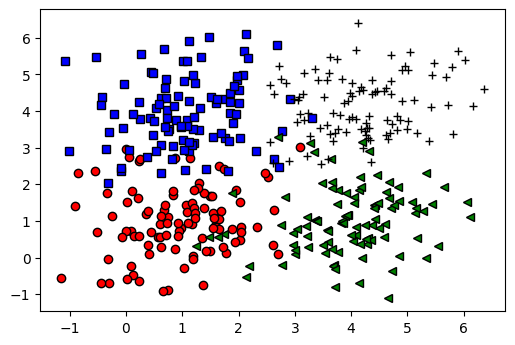

In [5]:
X_temp = np.hstack((X0, X1, X2, X3))
X = np.vstack((X_temp, np.ones((1, 4*N))))

y = np.array([0] * N + [1] * N + [2] * N + [3] * N)
print(X.shape)

plt.figure(dpi=100)

plt.plot(X0[0], X0[1], 'ro', markeredgecolor='k')
plt.plot(X1[0], X1[1], 'bs', markeredgecolor='k')
plt.plot(X2[0], X2[1], 'g<', markeredgecolor='k')
plt.plot(X3[0], X3[1], 'm+', markeredgecolor='k')


plt.show()


- epochs:       1,	loss:    6.2218326643
- epochs:     101,	loss:    4.5856836881
- epochs:     201,	loss:    3.7625356748
- epochs:     301,	loss:    3.3388755300
- epochs:     401,	loss:    3.0585223622
- epochs:     501,	loss:    2.8389548712
- epochs:     601,	loss:    2.6539577381
- epochs:     701,	loss:    2.4870717403
- epochs:     801,	loss:    2.3408104048
- epochs:     901,	loss:    2.2077700186
- epochs:    1001,	loss:    2.0850882187
- epochs:    1101,	loss:    1.9719745161
- epochs:    1201,	loss:    1.8669813900
- epochs:    1301,	loss:    1.7704084019
- epochs:    1401,	loss:    1.6935378610
- epochs:    1501,	loss:    1.6305201550
- epochs:    1601,	loss:    1.5747732700
- epochs:    1701,	loss:    1.5249535125
- epochs:    1801,	loss:    1.4810429712
- epochs:    1901,	loss:    1.4408796968
- epochs:    2001,	loss:    1.4041725214
- epochs:    2101,	loss:    1.3709254548
- epochs:    2201,	loss:    1.3410285643
- epochs:    2301,	loss:    1.3138497264
- epochs:    240

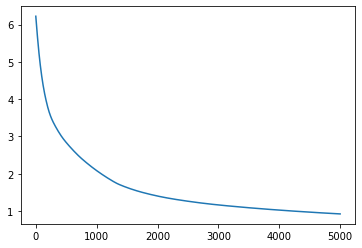

In [6]:
svm = MultiSVM(n_classes=4, learning_rate=1e-3)
svm.fit(X, y, epochs=5001, show_result=True)

In [7]:
y_pred = svm.predict(X)
print(y_pred)
svm.score(y_pred)

[2 2 2 0 0 2 0 0 2 0 0 2 0 0 0 2 0 1 0 0 0 0 1 2 0 0 2 0 0 0 0 2 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 1 0 2 2 1 0 0 0 0 2 0 1 2 2 0 0 0 0 2 0 0 2 0 1 0
 2 2 0 0 2 0 0 2 2 3 0 0 2 0 1 0 0 0 2 0 2 2 0 0 1 2 1 1 1 1 1 1 1 1 1 1 3
 1 1 1 1 1 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 1 0 0 1 1 1 1 1 3 1 1 1 3 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 3 2 2 2 2 2
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 1 3 3 3 3 1 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3]
accuracy rate: 84.0%


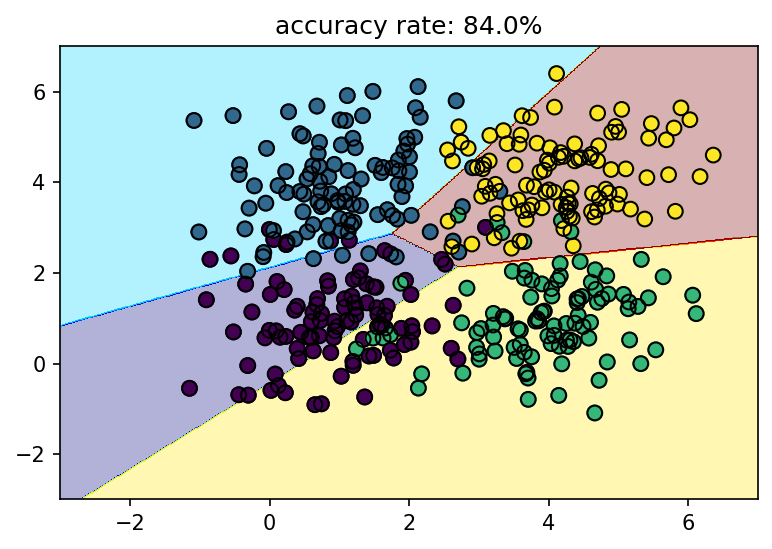

In [8]:
svm.visualize([-3, 7], [-3, 7], dpi=150)

# Deep Neural Network using Multi-class Support Vector Machine classifier

*Note: One hidden layer DNN*

## SUMMARY
- Diagram of neural network:

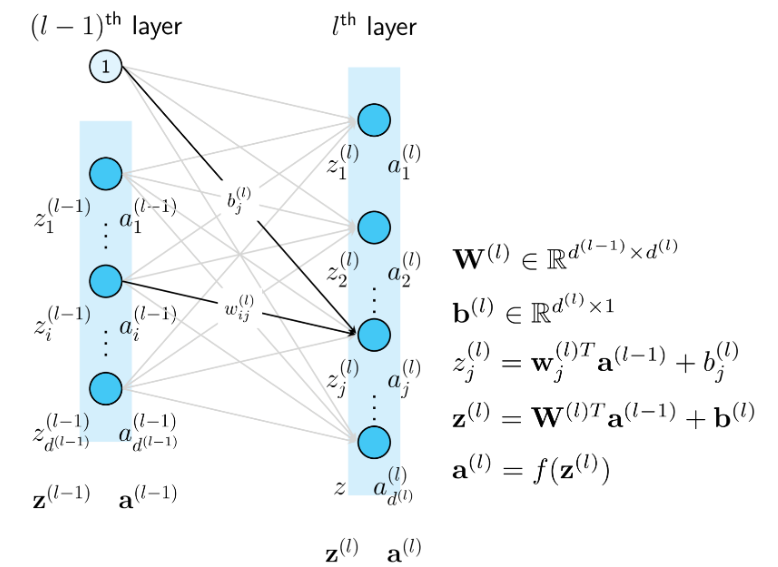

## With each coefficient $w_{ij}^{(l)}, b_{i}^{(l)}$
### Feedforward

- Activation function $f$ is ReLU: $\text{ReLU}(z) = \max(0, z)$
- Feedforward equation:

$\begin{eqnarray}
\mathbf{a}^{(0)} &=& \mathbf{x} \\ 
z_{i}^{(l)} &=& \mathbf{w}_i^{(l)T}\mathbf{a}^{(l-1)} + b_i^{(l)} \\ 
\mathbf{z}^{(l)}  &=& \mathbf{W}^{(l)T}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)},~~ l =  1, 2, \dots, L \\
\mathbf{a}^{(l)} &=& f(\mathbf{z}^{(l)}), ~~ l =  1, 2, \dots, L \\
\mathbf{\hat{y}} &=& \mathbf{a}^{(L)}
\end{eqnarray}$

### Backpropagation

1. Feedforward: For each input data point $\mathbf{x}$, compute corresponding output of network. During the computation, save the activation $\mathbf{a}^{(l)}$ at each layer.

2. With each unit $j$ at output layer, calculate:  $e_j^{(L)} = \frac{\partial J}{\partial z_j^{(L)}}$
 - $~J(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) + \frac{\lambda}{2} ||\mathbf{W}||_F^2~~~~$
 - $~e_j^{(L)} = \frac{\partial J}{\partial z_j^{(L)}} = \frac{\partial J}{\partial w_j^{(L)}}\frac{\partial w_j^{(L)}}{\partial z_j^{(L)}}$

3. For $l = L-1, L-2, …, 1$ calculate:  $e_j^{(l)} = \left( \mathbf{w}_{j:}^{(l+1)} \mathbf{e}^{(l+1)} \right) f’(z_j^{(l)})$

4. Update gradient of each coefficient:  $\begin{eqnarray}
\frac{\partial J}{\partial w_{ij}^{(l)}} &=& a_i^{(l-1)} e_j^{(l)} \ 
\frac{\partial J}{\partial b_{j}^{(l)}} &=& e_j^{(l)}
\end{eqnarray}$

## Gradient with matrix $\mathbf{W}^{(l)},~\mathbf{b}^{(l)}$
### Feedforward
$~~~~~~~~~~\begin{eqnarray}
\mathbf{A}^{(0)} &=& \mathbf{X} \\
\mathbf{Z}^{(1)} &=& \mathbf{W}^{(1)T}\mathbf{X} \\
\mathbf{A}^{(1)} &=& \max(\mathbf{Z}^{(1)}, \mathbf{0}) \\
\mathbf{Z}^{(2)} &=& \mathbf{W}^{(2)T}\mathbf{A}^{(1)} \\
\mathbf{\hat{Y}} &=& \mathbf{A}^{(2)} = \text{Multi-classSVM}(\mathbf{Z}^{(2)})
\end{eqnarray}$
### Backpropagation
$~~~~~\begin{eqnarray}
\mathbf{E}^{(2)} &=& \frac{\partial J}{\partial \mathbf{Z}^{(2)}} \\ 
\frac{\partial J}{\partial \mathbf{W}^{(2)}} &=& \mathbf{A}^{(1)}  \mathbf{E}^{(2)T} \\ 
\frac{\partial J}{\partial \mathbf{b}^{(2)}} &=& \sum_{n=1}^N\mathbf{e}_n^{(2)} \\ 
\mathbf{E}^{(1)} &=& \left(\mathbf{W}^{(2)}\mathbf{E}^{(2)}\right) \odot f’(\mathbf{Z}^{(1)}) \\ 
\frac{\partial J}{\partial \mathbf{W}^{(1)}} &=& \mathbf{A}^{(0)}  \mathbf{E}^{(1)T} = \mathbf{X}\mathbf{E}^{(1)T}\\ 
\frac{\partial J}{\partial \mathbf{b}^{(1)}} &=& \sum_{n=1}^N\mathbf{e}_n^{(1)} \\ 
\end{eqnarray}$

- **Find $\mathbf{E}^{(2)} = \frac{\partial J}{\partial \mathbf{Z}^{(2)}}$:**

$J(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - (\mathbf{w}_{y_n}^T \mathbf{x}_n + b_{y_n}) + (\mathbf{w}_j^T\mathbf{x}_n + b_j)) + \frac{\lambda}{2} ||\mathbf{W}||_F^2$
- We consider a data point $\mathbf{x}_i$ and let $z_{ji} = \mathbf{w}_j^T\mathbf{x}_i + b_j$. Here, we temporarily ignore the regularization loss part and coeff $\frac{1}{N}$:

$\begin{eqnarray}
J_i(\mathbf{X}_i, \mathbf{y}_i, \mathbf{W}) &=& \sum_{j \neq y_i} \max(0, 1 - (\mathbf{w}_{y_i}^T \mathbf{x}_i+ b_{y_i}) + (\mathbf{w}_j^T\mathbf{x}_i+b_j))\\
&=& \sum_{j \neq y_i} \max(0, 1 - z_{y_ii} + z_{ji})\\
\end{eqnarray}$

$\begin{eqnarray}
⇒ \frac{∂J_i(\mathbf{W})}{∂z_{ji}} &=& 1 ~~\text{if} ~~1 - z_{y_ii} + z_{ji} > 0\\
\frac{∂J_i(\mathbf{W})}{∂z_{y_ii}} &=& -1 ~~\text{if} ~~1 - z_{y_ii} + z_{ji} > 0\\
\text{else} &=& 0
\end{eqnarray}$

$⇒ \frac{∂J(\mathbf{W})}{∂\mathbf{Z}} = λ\mathbf{W}^T\mathbf{X}^{{\dagger}T}$

- Remember to multiply by $\frac{1}{N}$.

## Implementation

In [9]:
# check gradient

w_hi = np.random.rand(16, 4)
x_hihi = np.random.rand(16, 5)
b_hihi = np.random.rand(4, 1)


In [10]:
z_hihi = w_hi.T @ x_hihi + b_hihi
t_Z_hi = ((z_hihi - b_hihi) @ np.linalg.pinv(x_hihi)).T
# print(w_hi)
# print(t_Z_hi)

def cost1(z):
  w = ((z - b_hihi) @ np.linalg.pinv(x_hihi)).T
  return np.sum(w * w)

def grad():
  return 2 * (w_hi.T @ np.linalg.pinv(x_hihi).T)

def numgr():
  eps = 1e-6
  fz = z_hihi.flatten()
  g = np.zeros_like(fz)
  for i in range(z_hihi.size):
    wp = fz.copy()
    wn = fz.copy()
    wp[i] += eps
    wn[i] -= eps
    g[i] = (cost1(wp.reshape(z_hihi.shape)) - cost1(wn.reshape(z_hihi.shape))) / (2 * eps)

  return g.reshape(z_hihi.shape)

g1 = grad()
g2 = numgr()
print(g1)
print(g2)
print('gradient different: ', np.linalg.norm(g1-g2))

[[ 0.08409063  1.12702145 -0.39676674 -0.08884163  0.75428923]
 [-0.31578747 -0.04976578  0.61970472  0.32284059  1.11288249]
 [ 0.14850703 -0.17594165  1.70061707  0.40743077 -0.1079976 ]
 [ 0.61113481  0.91521023 -0.64384337 -0.18238141  0.89310796]]
[[ 0.08409063  1.12702145 -0.39676674 -0.08884163  0.75428923]
 [-0.31578747 -0.04976578  0.61970472  0.32284059  1.11288249]
 [ 0.14850703 -0.17594165  1.70061707  0.40743076 -0.1079976 ]
 [ 0.61113481  0.91521023 -0.64384337 -0.18238141  0.89310796]]
gradient different:  5.36583255157389e-09


In [96]:
class DNN_SVM:
  def __init__(self, n_classes, units, learning_rate=1e-3, reg=0., delta=1):
    if len(units) != 3:
      raise ValueError('Illegal Argument Exception')
    if units[2] != n_classes:
      raise ValueError('Illegal Argument Exception')
    if min(units) < 2:
      raise ValueError('Invalid number of units in a layer!')
      
    self.n_classes_ = n_classes
    self.units_ = units
    self.__lr = learning_rate
    self.__reg = reg
    self.__delta = delta
    self.loss_ = []  

  def __init_coeff_matrix(self):
    self.__h = self.units_[1]
    self.__W1 = 0.1*np.random.randn(self.units_[0], self.units_[1])
    self.__b1 = np.zeros((self.units_[1], 1))
    self.__W2 = 0.1*np.random.randn(self.units_[1], self.units_[2])
    self.__b2 = np.zeros((self.units_[2], 1))

  def __loss_function(self, X, y):
    if self.__W2 is None:
      raise ValueError('MultiSVM has not been fitted yet!')
    Z = self.__W2.T @ X + self.__b2# [C, d] x [d, N] = [C, n]
    correct_class = np.choose(y, Z)

    hinge = np.maximum(0, Z - correct_class + self.__delta)
    hinge[y, range(X.shape[1])] = 0

    loss =  np.sum(hinge) / X.shape[1] + 0.5 * self.__reg * np.sum(self.__W2 * self.__W2)
    hinge[hinge > 0] = 1
    hinge[y, range(X.shape[1])] = -np.sum(hinge, axis=0)

    dw = X @ hinge.T / X.shape[1] + self.__reg * self.__W2
    #    [C, n]           +                [C, d1] x [d1, n]
    E2 = hinge / X.shape[1] + self.__reg * self.__W2.T @ np.linalg.pinv(X).T
    return loss, dw, E2
  
  def fit(self, X, y, batch_size=0, epochs=1001, show_result=False):
    if self.units_[0] != X.shape[0]:
      raise ValueError('Illegal Argument Exception')
    if batch_size == 0:
      batch_size = X.shape[1]
    else:
      if X.shape[1] % batch_size != 0:
        raise ValueError('number of data points must be divisible by batch_size!')
    self.__init_coeff_matrix()
    self.X = X
    self.y = y
    check_ep = 100
    iter_per_epoch = X.shape[1] // batch_size
    self.loss_ = []
    
    # mini-batch gradient descent
    for ep in range(epochs):
      mix_id = np.random.permutation(X.shape[1])
      for j in range(iter_per_epoch):
        id = mix_id[range(j * batch_size, batch_size * (j + 1))]
        yt = y[id]
        Xt = X[:, id]
        # Feedforward
        Z1 = self.__W1.T @ Xt + self.__b1 # [d1, d0] x [do, n] = [d1, n]
        A1 = np.maximum(Z1, 0) # ReLU(Z) - Activation function
        Z2 = self.__W2.T @ A1 + self.__b2 # [d2, d1] x [d1, n] = [d2, n]

        # Backpropagation
        loss, dW2, E2 = self.__loss_function(A1, yt)
        db2 = np.sum(E2, axis=1, keepdims=True)
        E1 = self.__W2 @ E2 # [d1, n]
        E1[Z1 <= 0] = 0
        dW1 = Xt @ E1.T # [d0, n] x [n, d1]
        db1 = np.sum(E1, axis=1, keepdims=True)

        self.__W1 -= self.__lr * dW1
        self.__b1 -= self.__lr * db1
        self.__W2 -= self.__lr * dW2
        self.__b2 -= self.__lr * db2
      self.loss_.append(loss)
      if show_result and (ep % check_ep == 0):
        print('- epochs: {ep:7d},\tloss: {loss:-15.10f}'.format(ep = ep + 1, loss = loss))

    self.loss_ = np.array([self.loss_]).T
    if show_result:
      print('Histogram of Loss value:')
      plt.figure(figsize=(18, 6))
      plt.plot(self.loss_)
      plt.show()
    
  def decision_function(self, X):
    # duplicate code
    Z1 = self.__W1.T @ X + self.__b1 # [d1, d0] x [do, n] = [d1, n]
    A1 = np.maximum(Z1, 0) # ReLU(Z) - Activation function
    return self.__W2.T @ A1 + self.__b2 # [d2, d1] x [d1, n] = [d2, n]

  def predict(self, X):
    return np.argmax(self.decision_function(X), axis=0)

  def score(self, y1, y2 = None):
    if y2 is None:
      y2 = self.y
    
    print(f'accuracy rate: {accuracy_score(y1, y2) * 100}%')

  def visualize(self, x_axis, y_axis, n_=500, level_sets=200, dpi=100):
    plt.figure(dpi=dpi)

    x_ = np.linspace(x_axis[0], x_axis[1], n_)
    y_ = np.linspace(y_axis[0], y_axis[1], n_)

    x_, y_ = np.meshgrid(x_, y_)

    xx = x_.reshape(-1)
    yy = y_.reshape(-1)
    x = np.vstack((xx, yy))
    z = self.predict(x)
    z = z.reshape(n_, n_)

    plt.contourf(x_, y_, z, level_sets, cmap='jet', alpha = .3)

    plt.scatter(self.X[0], self.X[1], s=50, c=self.y) #, markeredgecolor='k')

    plt.scatter(self.X[0], self.X[1], s=50,
                   linewidth=1, marker='o', facecolors='none', edgecolors='k')
      
    plt.axis('tight')
    plt.title(f'accuracy rate of DNN: {accuracy_score(self.y, self.predict(self.X)) * 100}%')

    plt.show()

(2, 400)


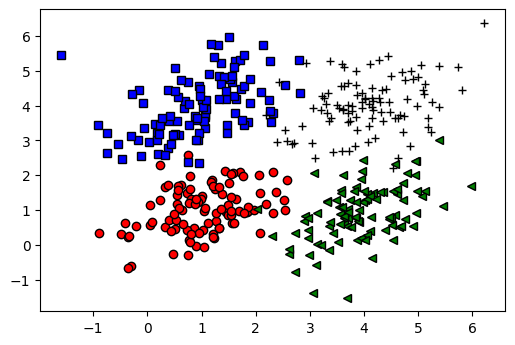

In [12]:
means2 = [[1, 1],
         [1, 4],
         [4, 1],
         [4, 4]]

cov2 = [[.6, .2],
       [.2, .6]]

N2 = 100

X0_ = np.random.multivariate_normal(means2[0], cov2, N2).T
X1_ = np.random.multivariate_normal(means2[1], cov2, N2).T
X2_ = np.random.multivariate_normal(means2[2], cov2, N2).T
X3_ = np.random.multivariate_normal(means2[3], cov2, N2).T

X_train_2 = np.hstack((X0_, X1_, X2_, X3_))
print(X_train_2.shape)

y_train_2 = np.array([0] * N2 + [1] * N2 + [2] * N2 + [3] * N2)

plt.figure(dpi=100)

plt.plot(X0_[0], X0_[1], 'ro', markeredgecolor='k')
plt.plot(X1_[0], X1_[1], 'bs', markeredgecolor='k')
plt.plot(X2_[0], X2_[1], 'g<', markeredgecolor='k')
plt.plot(X3_[0], X3_[1], 'm+', markeredgecolor='k')

plt.show()


- epochs:       1,	loss:    2.9760607138
- epochs:     101,	loss:    0.8237757804
- epochs:     201,	loss:    0.5110076172
- epochs:     301,	loss:    0.3078036717
- epochs:     401,	loss:    0.2817862901
- epochs:     501,	loss:    0.2451399874
- epochs:     601,	loss:    0.2056007423
- epochs:     701,	loss:    0.1589314178
- epochs:     801,	loss:    0.1107797524
- epochs:     901,	loss:    0.1130902255
- epochs:    1001,	loss:    0.1626581512
- epochs:    1101,	loss:    0.1163737330
- epochs:    1201,	loss:    0.1250910746
- epochs:    1301,	loss:    0.0992334052
- epochs:    1401,	loss:    0.1204738075
- epochs:    1501,	loss:    0.0343874452
- epochs:    1601,	loss:    0.0570143507
- epochs:    1701,	loss:    0.0927002512
- epochs:    1801,	loss:    0.0872346093
- epochs:    1901,	loss:    0.0465481501
- epochs:    2001,	loss:    0.1143975086
Histogram of Loss value:


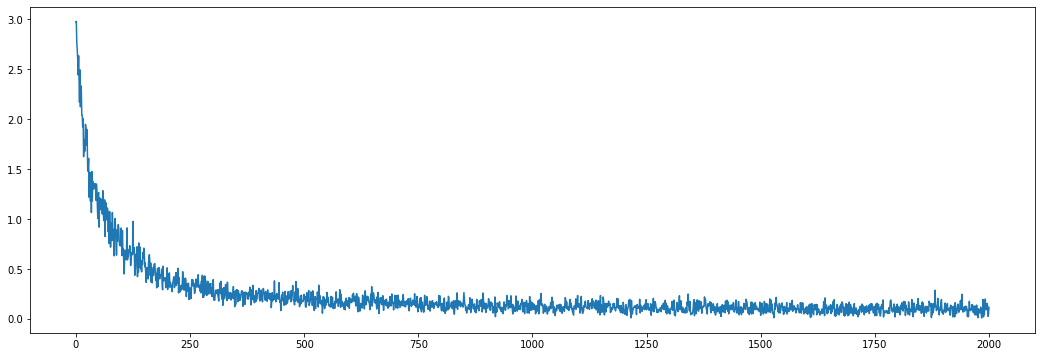

In [13]:
dnn = DNN_SVM(n_classes=4, units=[2, 50, 4], delta=1, learning_rate=0.001)
dnn.fit(X_train_2, y_train_2, batch_size=50, epochs=2001, show_result=True)

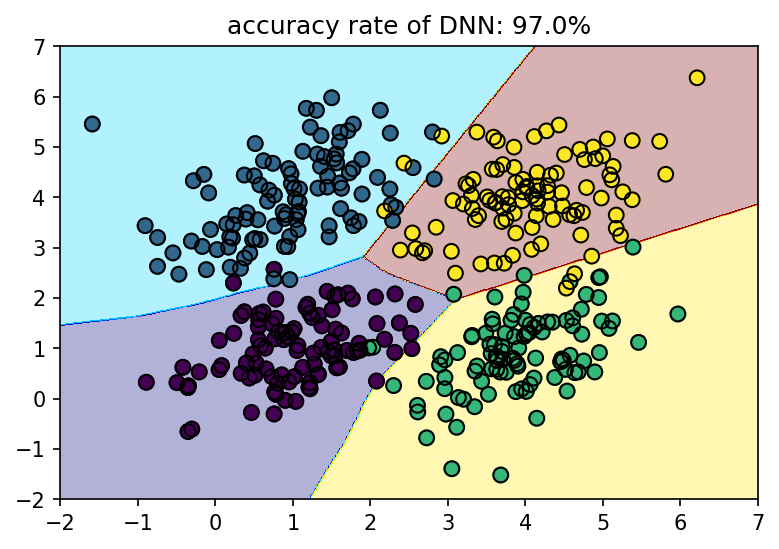

In [14]:
dnn.visualize([-2, 7], [-2, 7], dpi=150)

## Moon dataset (2 classes)

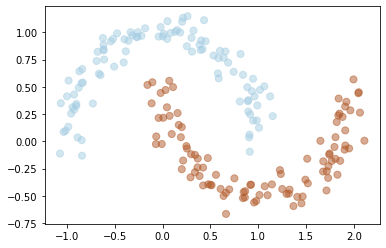

In [20]:
def make_moon_data(n_samples, noise=0.1):
  noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=6)
  return noisy_moons[0], noisy_moons[1]


n_data = 200
X_moon, y_moon = make_moon_data(n_data)
X_moon = X_moon.T
# y_moon = y_moon.reshape(1, n_data)


plt.scatter(X2[0], X2[1], c=y_moon, s=50, cmap=plt.cm.Paired, alpha=.5)
plt.show()


- epochs:       1,	loss:    0.9416395111
- epochs:     101,	loss:    0.3146101563
- epochs:     201,	loss:    0.3577626183
- epochs:     301,	loss:    0.2672229206
- epochs:     401,	loss:    0.2650777422
- epochs:     501,	loss:    0.2136034625
- epochs:     601,	loss:    0.2063923248
- epochs:     701,	loss:    0.1733366665
- epochs:     801,	loss:    0.0881675340
- epochs:     901,	loss:    0.2390037761
- epochs:    1001,	loss:    0.1085472034
- epochs:    1101,	loss:    0.0906427053
- epochs:    1201,	loss:    0.0915632150
- epochs:    1301,	loss:    0.0491930930
- epochs:    1401,	loss:    0.0733431958
- epochs:    1501,	loss:    0.0219023996
- epochs:    1601,	loss:    0.0314267943
- epochs:    1701,	loss:    0.0196738286
- epochs:    1801,	loss:    0.0381869240
- epochs:    1901,	loss:    0.0247329006
- epochs:    2001,	loss:    0.0243839096
Histogram of Loss value:


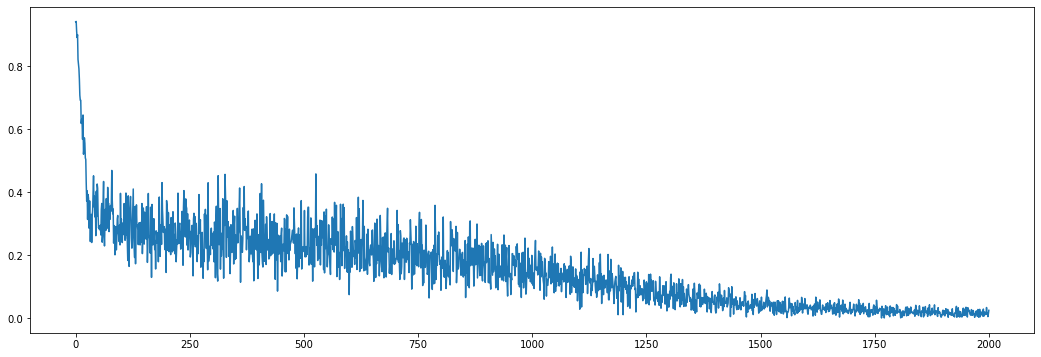

In [27]:
dnn_moon = DNN_SVM(n_classes=2, units=[2, 100, 2], delta=1, learning_rate=0.01)
dnn_moon.fit(X_moon, y_moon, batch_size=50, epochs=2001, show_result=True)

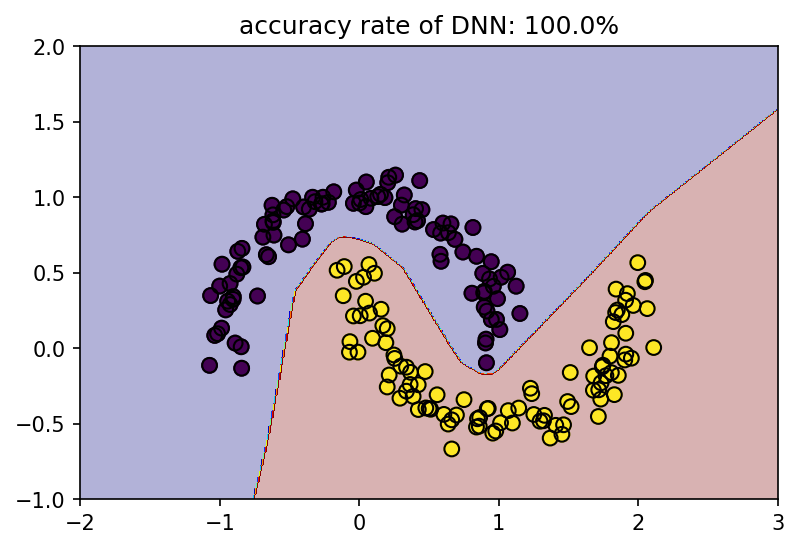

In [28]:
dnn_moon.visualize([-2, 3], [-1, 2], dpi=150)

# CIFAR-10 dataset

In [83]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# get the first 2000 train data and 200 test data
x_train = x_train[:2000] / 255.0
y_train = y_train[:2000].ravel()
x_test = x_test[:200] / 255.0
y_test = y_test[:200].ravel()

## Feature Engineering

In [77]:
# feature engineering: disable grayscale
X_train = x_train.reshape(x_train.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

### Using Multi-class SVM with Mini-batch Gradient Descent

- epochs:       1,	loss: 1556.0708643311
- epochs:     101,	loss:   33.9985169737
- epochs:     201,	loss:    5.6207451902
- epochs:     301,	loss:    6.3138595647
- epochs:     401,	loss:    5.5073361828
- epochs:     501,	loss:    7.0331682792
- epochs:     601,	loss:    7.0435325450
- epochs:     701,	loss:    7.1875310213
- epochs:     801,	loss:    7.2650457044
- epochs:     901,	loss:    6.4596664540
- epochs:    1001,	loss:    7.9329545164
- epochs:    1101,	loss:    8.0271221114
- epochs:    1201,	loss:    5.6508511827
- epochs:    1301,	loss:    5.7963633065
- epochs:    1401,	loss:    6.0319120214
- epochs:    1501,	loss:    5.9350180975
- epochs:    1601,	loss:    5.7028489989
- epochs:    1701,	loss:    7.5821056406
- epochs:    1801,	loss:    5.6875905273
- epochs:    1901,	loss:    4.5344892178
- epochs:    2001,	loss:    6.7830676502
- epochs:    2101,	loss:    7.2264711184
- epochs:    2201,	loss:    5.1884683173
- epochs:    2301,	loss:    8.1732279318
- epochs:    240

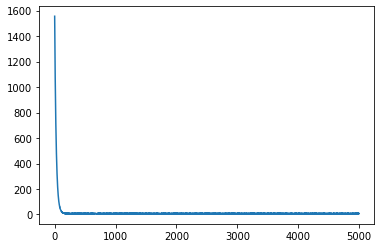

In [92]:
X1_train = np.vstack((X_train.T, np.ones((1, X_train.shape[0]))))

mSVM = MultiSVM(n_classes=10, learning_rate=1e-2)
mSVM.fit(X1_train, y_train, batch_size=100, epochs=5001, show_result=True)

In [108]:
X1_test = np.vstack((X_test.T, np.ones((1, X_test.shape[0]))))

y1_pred = mSVM.predict(X1_test)
mSVM.score(y1_pred, y_test)
# quite low percentage.

accuracy rate: 22.5%


### Using DNN with Multi-class SVM classifier

- epochs:       1,	loss:    8.2835552880
- epochs:     101,	loss:    4.0074049436
- epochs:     201,	loss:    2.8856142959
- epochs:     301,	loss:    2.5940500911
- epochs:     401,	loss:    2.2149953883
- epochs:     501,	loss:    1.4547573782
- epochs:     601,	loss:    1.6749929150
- epochs:     701,	loss:    0.9734112653
- epochs:     801,	loss:    1.1436423074
- epochs:     901,	loss:    0.8825554747
- epochs:    1001,	loss:    0.7398217284
- epochs:    1101,	loss:    0.5481225416
- epochs:    1201,	loss:    0.5482439013
- epochs:    1301,	loss:    0.2562544591
- epochs:    1401,	loss:    0.4365380472
- epochs:    1501,	loss:    0.3043621353
- epochs:    1601,	loss:    0.3193525177
- epochs:    1701,	loss:    0.1942389139
- epochs:    1801,	loss:    0.2468528524
- epochs:    1901,	loss:    0.2959373381
- epochs:    2001,	loss:    0.1622930327
- epochs:    2101,	loss:    0.1119401475
- epochs:    2201,	loss:    0.1388542298
- epochs:    2301,	loss:    0.0998311371
- epochs:    240

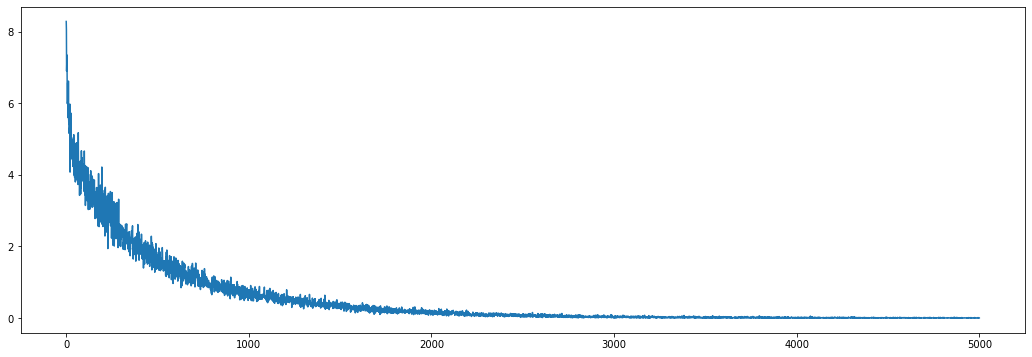

In [97]:
dnn1 = DNN_SVM(n_classes=10, units=[3072, 50, 10], delta=1, learning_rate=0.001)
dnn1.fit(X_train.T, y_train, batch_size=100, epochs=5001, show_result=True)

In [109]:
y2_pred = dnn1.predict(X_test.T)
print(y2_pred)
print(y_test)
dnn1.score(y2_pred, y_test)
# quite low percentage. But still higher than the first algorithm

[3 1 1 8 4 3 3 6 2 1 0 9 5 7 1 0 6 5 8 6 6 0 0 9 4 2 6 0 5 6 1 5 2 2 8 7 3
 9 4 5 7 6 7 4 0 9 4 8 4 4 9 8 6 3 8 0 2 8 5 8 6 5 7 1 6 5 1 2 3 1 2 5 0 8
 7 6 0 0 0 8 8 7 5 2 2 9 2 8 8 8 0 6 8 6 4 4 6 0 7 3 7 5 6 7 8 1 5 1 5 3 2
 2 6 4 5 1 2 2 2 9 8 4 2 6 8 5 0 3 7 2 4 0 9 7 2 0 1 7 6 1 4 0 9 5 8 3 5 3
 5 5 8 0 2 7 0 5 3 0 6 0 0 1 3 7 0 7 8 3 6 7 9 7 2 8 0 1 8 7 3 9 1 7 6 4 4
 0 2 3 7 9 4 3 3 3 0 2 9 0 5 0]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4
 0 6 2 1 3 0 4 2 7 8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2
 5 2 8 9 6 0 0 5 2 9 5 4 2 1 6 6 8 4 8 4 5 0 9 9 9 8 9 9 3 7 5 0 0 5 2 2 3
 8 6 3 4 0 5 8 0 1 7 2 8 8 7 8]
accuracy rate: 31.5%


## Feature Enginnering applied grayscale.

In [106]:
# feature engineering: grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])
X_train_gray = x_train_gray.reshape(x_train_gray.shape[0], -1).T
X_test_gray = x_test_gray.reshape(x_test_gray.shape[0], -1).T


### Using Multi-class SVM with Mini-batch Gradient Descent

- epochs:       1,	loss:  529.6440994788
- epochs:     101,	loss:   13.8194787256
- epochs:     201,	loss:    5.8887106334
- epochs:     301,	loss:    6.4867265856
- epochs:     401,	loss:    5.8801061963
- epochs:     501,	loss:    5.6772360477
- epochs:     601,	loss:    6.1933200810
- epochs:     701,	loss:    6.6139209157
- epochs:     801,	loss:    6.2419439811
- epochs:     901,	loss:    5.4179632140
- epochs:    1001,	loss:    5.9933308256
- epochs:    1101,	loss:    5.7328252836
- epochs:    1201,	loss:    6.7708311948
- epochs:    1301,	loss:    5.9995824772
- epochs:    1401,	loss:    6.3990105844
- epochs:    1501,	loss:    6.0813289231
- epochs:    1601,	loss:    5.5818495850
- epochs:    1701,	loss:    6.1389007116
- epochs:    1801,	loss:    5.6980185505
- epochs:    1901,	loss:    5.7976164058
- epochs:    2001,	loss:    6.3838903221
- epochs:    2101,	loss:    5.6362444648
- epochs:    2201,	loss:    5.9370225929
- epochs:    2301,	loss:    5.9668177360
- epochs:    240

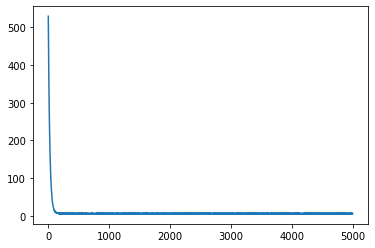

In [110]:
X1_train_gray = np.vstack((X_train_gray, np.ones((1, X_train_gray.shape[1]))))

mSVM = MultiSVM(n_classes=10, learning_rate=1e-2)
mSVM.fit(X1_train_gray, y_train, batch_size=100, epochs=5001, show_result=True)

In [114]:
X1_test_gray = np.vstack((X_test_gray, np.ones((1, X_test_gray.shape[1]))))
y1_pred_gray = mSVM.predict(X1_test_gray)
print(y1_pred_gray)
print(y_test)
mSVM.score(y1_pred_gray, y_test)
# low percentage.

[2 1 8 2 5 3 3 2 2 1 3 1 5 8 7 5 6 2 8 7 5 2 2 1 2 1 5 8 1 3 1 2 3 2 8 2 2
 1 3 2 3 2 3 3 2 3 5 3 2 3 1 2 3 8 8 8 2 8 3 2 5 5 6 1 3 3 1 2 3 9 2 5 2 8
 9 3 1 5 1 1 3 8 2 5 2 2 5 8 8 1 1 2 8 3 7 3 5 3 2 3 2 2 5 0 3 1 5 1 5 4 2
 2 1 2 1 2 2 9 5 5 1 5 1 2 2 3 3 3 2 2 2 1 1 7 7 3 9 2 5 1 5 1 3 2 8 3 5 5
 5 5 8 2 3 3 4 5 5 1 5 2 2 1 2 5 8 7 1 3 7 8 1 3 1 5 3 1 2 3 2 2 1 3 2 2 3
 5 1 2 2 7 8 3 2 3 3 5 3 2 3 5]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4
 0 6 2 1 3 0 4 2 7 8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2
 5 2 8 9 6 0 0 5 2 9 5 4 2 1 6 6 8 4 8 4 5 0 9 9 9 8 9 9 3 7 5 0 0 5 2 2 3
 8 6 3 4 0 5 8 0 1 7 2 8 8 7 8]
accuracy rate: 18.5%


### Using DNN with Multi-class SVM classifier

- epochs:       1,	loss:    8.8065907363
- epochs:     101,	loss:    5.4981019017
- epochs:     201,	loss:    4.9633408342
- epochs:     301,	loss:    3.8343671467
- epochs:     401,	loss:    3.5002860738
- epochs:     501,	loss:    2.6353062845
- epochs:     601,	loss:    2.9227872800
- epochs:     701,	loss:    2.6148480150
- epochs:     801,	loss:    2.3507906180
- epochs:     901,	loss:    1.9444415718
- epochs:    1001,	loss:    1.7442770792
- epochs:    1101,	loss:    1.5052616719
- epochs:    1201,	loss:    1.7485851594
- epochs:    1301,	loss:    1.2362148746
- epochs:    1401,	loss:    1.1926953402
- epochs:    1501,	loss:    1.1647443420
- epochs:    1601,	loss:    0.9337995222
- epochs:    1701,	loss:    1.0503940485
- epochs:    1801,	loss:    0.8442789031
- epochs:    1901,	loss:    0.6510376624
- epochs:    2001,	loss:    0.6985187896
- epochs:    2101,	loss:    0.6909491896
- epochs:    2201,	loss:    0.5025437176
- epochs:    2301,	loss:    0.5146830139
- epochs:    240

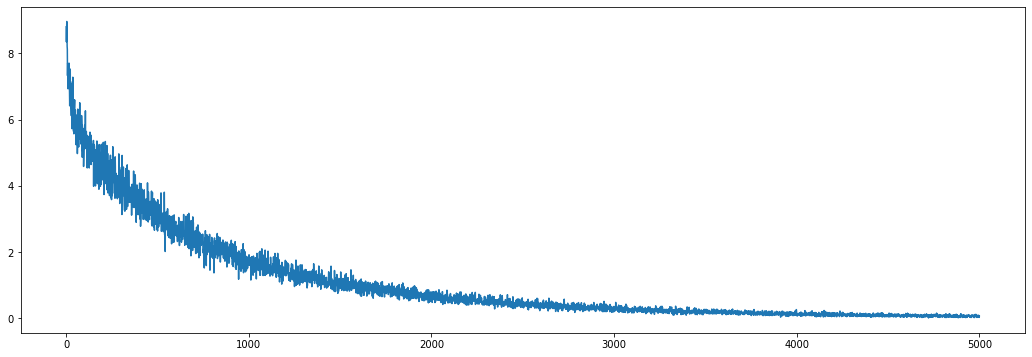

In [115]:
dnn2 = DNN_SVM(n_classes=10, units=[1024, 50, 10], delta=1, learning_rate=0.001)
dnn2.fit(X_train_gray, y_train, batch_size=100, epochs=5001, show_result=True)

In [116]:
y2_pred_gray = dnn2.predict(X_test_gray)
print(y2_pred_gray)
print(y_test)
dnn1.score(y2_pred_gray, y_test)
# quite low percentage. But still higher than the first algorithm

[3 8 1 8 1 3 4 6 4 9 0 9 7 7 1 0 7 2 8 1 1 0 4 5 4 6 9 7 5 4 6 0 8 5 3 7 4
 9 4 7 7 4 7 4 0 3 1 4 2 4 9 0 9 0 9 8 5 1 3 4 4 4 7 9 3 5 1 0 3 1 2 2 0 8
 7 3 1 7 6 8 8 1 4 2 4 8 3 8 0 8 0 2 8 5 4 3 3 2 5 3 5 1 6 5 8 1 4 3 8 5 2
 2 9 2 9 9 4 4 2 6 8 4 2 0 8 6 9 5 4 2 4 0 9 5 6 5 8 2 6 1 8 0 9 7 9 3 6 5
 6 9 9 4 7 7 0 5 2 5 4 2 2 1 1 3 7 7 4 0 3 7 9 0 0 0 4 1 6 7 2 0 3 5 2 2 4
 8 4 5 7 7 0 3 4 1 6 2 8 8 5 5]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4
 0 6 2 1 3 0 4 2 7 8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2
 5 2 8 9 6 0 0 5 2 9 5 4 2 1 6 6 8 4 8 4 5 0 9 9 9 8 9 9 3 7 5 0 0 5 2 2 3
 8 6 3 4 0 5 8 0 1 7 2 8 8 7 8]
accuracy rate: 26.0%
